# This Notebook is for EDA and Clean-up of the provided data set for the Machine Learning course
## TODO List (in addition to in-line):
- Encode additional variables for use
- Determine how to encode diags -- Don't know what to do yet
- Try scaling features
- Implement gradient boosting
- Implement N.N

## Set Up

In [513]:
# Standard Libraries
import pandas as pd
import numpy as np
import os
import warnings

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SkLearn  Data Prep
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# SkLearn Measurement Libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import  precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# SkLearn Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import model_selection

# set Theme
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

In [514]:
# Get Main Data
path = os.getcwd()
path = path +'\\medical_data\\'
file = 'data.csv'

mainData = pd.read_csv(path+file)
mainData.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
0,24437208,135,Caucasian,Female,[50-60),NaN,2,1,1,8,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
1,29758806,378,Caucasian,Female,[50-60),NaN,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
2,189899286,729,Caucasian,Female,[80-90),NaN,1,3,7,4,...,No,No,No,No,No,No,No,No,Yes,NO
3,64331490,774,Caucasian,Female,[80-90),NaN,1,1,7,3,...,No,No,No,No,No,No,No,Ch,Yes,NO
4,14824206,927,AfricanAmerican,Female,[30-40),NaN,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,NO


In [515]:
# Get Admission Type Look-Up
file = 'id_lookup.csv'
admissionTypeLookUp = pd.read_csv(path+file)
admissionTypeLookUp = admissionTypeLookUp.iloc[:8]
admissionTypeLookUp['admission_type_id'] = admissionTypeLookUp['admission_type_id'].astype(int)
admissionTypeLookUp

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


In [516]:
# Set Aside Copy of DF for Experiments
expData = mainData

## Re-Usable Functions

In [517]:
def OrdinalEncoderFunc (df,listOfVars,order):
    df=df
    order=order
    enc = OrdinalEncoder(categories=[order])
    for col in listOfVars:
        col=col
        df[col] = enc.fit_transform(df[[col]])
    return df

In [518]:
def nullAnalysis(df):
    row = []
    null_summaryDF = pd.DataFrame(columns = ["Variable","Observations","Nulls","Null_Per","Num_Unique","Type"])
    for column in df:
        var = column
        countOfObs = len(df[var])
        countOfNull = df[var].isnull().sum()
        perOfNull = round((100 * countOfNull) / countOfObs,3)
        numUnique = df[var].nunique()
        type  = df[var].dtypes
        # Append to Summary DF
        row = [var, countOfObs,countOfNull,perOfNull,numUnique,type]
        df_length = len(null_summaryDF)
        null_summaryDF.loc[df_length] = row
    # Get Summary Stats
    countofVars = len(null_summaryDF)
    countofNotNull = (null_summaryDF['Nulls'] == 0).sum()
    countofNull = (null_summaryDF['Nulls'] != 0).sum()
    print(f"Count of Variables:",countofVars)
    print(f"Count of Variables without nulls:",countofNotNull)
    print(f"Count of Variables with null :",countofNull)
    # Format Summary
    summaryDF = null_summaryDF[null_summaryDF['Nulls'] != 0].sort_values(by=['Nulls'],ascending=False)
    return summaryDF

In [519]:
# Custom Clean-Up Function For This Dataset -- 1
def EncodeResponse (df):
    df=df
    # Execute Encoding
    dummyTemp = pd.get_dummies(df['readmitted'],prefix='readmitted_')
    df = df.join(dummyTemp)
    # Customize/ Clean-Up
    ## Make 'readmitted' more logical so it is 0 when no and 1 when yes
    df = df.drop(columns=['readmitted']) # Drop Old Readmitted Column
    df = df.rename(columns={'readmitted__NO': 'readmitted'}) # Rename encoded column
    df = df.dropna(subset=['readmitted']) # drop puzzling 1 nan value
    df['readmitted'] = df['readmitted'].map({0:1, 1:0}) # reverse encoding to make logical
    return df

In [520]:
mainData['max_glu_serum'].value_counts(dropna=False)

None    68062
Norm     1731
>200      969
>300      756
Name: max_glu_serum, dtype: int64

In [521]:
# Custom Clean-Up Function For This Dataset -- 2
# TODO: Clean-up for demographic Vars (age, gender, race)

def AdditionalClean (df):
    df=df
    #1 - Null Clean-Up2 -- Fillna's for variables with nulls that have value to keep
    df['race'] = df['race'].fillna('Unknown')
    #2 - Race to Dummy Vars
    dummyTemp = pd.get_dummies(df['race'],prefix='race_')
    df = df.join(dummyTemp)
    df = df.drop(columns=['race'])
    #2 - Encode Gender
    number = LabelEncoder()
    df['gender'] = number.fit_transform(df['gender']) # F -> 1, M -> 0, Unknown -> 2
    #3 Custom Encode 1 -  A1Cresult
    mapping_a1 = {'None':0,'Norm':0,'>7':1,'>8':2}
    df['A1Cresult'] = df['A1Cresult'].map(mapping_a1)
    #3 Custom Encode 2 -  max_glu_serum
    mapping_glu = {'None':0,'Norm':0,'>200':1,'>300':2}
    df['max_glu_serum'] = df['max_glu_serum'].map(mapping_glu)
    #4 - Covnert Age Buckets to Single Numeric
    df['age'] = df['age'].str[1:3]
    df['age'] = df['age'].str.rstrip('-')
    df['age'] = df['age'].astype('int')
    df = df.rename(columns={'age': 'age_10yrStart'})
    #Final - EncodeResponse
    df = EncodeResponse(df)
    return df

In [522]:
#  Split function
## Note: set test size to 20%

def testTrainSplit (df, PredictorVar,ResponseVar):
    df=df
    # Split into training/test
    x = df[PredictorVar]
    y = df[ResponseVar]
    # Split Data Set Seed NP Random
    np.random.seed(1) # seed np random
    ## split data - use "random_state = any number (42) if you want reproducable splits.
    ### Remove random-state if you want random
    x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size = 0.2)
    return x_train, x_test, y_train, y_test


In [523]:
def ROC_Curve_Plot(model,roc_x_test,roc_y_test):
    probas = model.predict_proba(roc_x_test) # get the probability distribution
    fpr, tpr, thresholds = roc_curve(roc_y_test, probas[:,0], pos_label=0) # get false and true positive rates
    roc_auc = auc(fpr, tpr) # get area under curve
    # PLOT ROC curve
    plt.figure(dpi=150)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], '--k', lw=0.5, label='Random')
    plt.title('ROC Curve for RF classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    return plt


In [524]:
def createConfMatrix (regObj, y_test, y_pred, x_test):
    # Logistic Regression -- Step 5 -- Create Confusion Matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    cm.columns.name = 'Predicted'
    cm.index.name = 'True'
    # Logistic Regression -- Step 6 -- Calc Accuracy From Test Set
    score = regObj.score(x_test, y_test)
    score = round(score,4)
    return cm, score

In [525]:
def precisionRecall (y_test, y_pred):
    precision = round(precision_score(y_test, y_pred),4)
    recall = round(recall_score(y_test, y_pred),4)
    f1 = round(f1_score(y_test, y_pred),4)
    return precision, recall, f1

In [526]:
def FeatureImportance (regObj):
    # Best Tree-- Plot Most Important Features
    importances = rndClf.feature_importances_
    #Convert Array to DF
    feature_importances = pd.Series(importances, index=PredictorVar)
    feature_importances = feature_importances.to_frame().reset_index()
    feature_importances = feature_importances.rename(columns={'index':'feature',0:'impDecrease'})
    feature_importances = feature_importances.sort_values(by='impDecrease',ascending=False)
    #std = np.std([tree.feature_importances_ for tree in cv_bestTree.estimators_], axis=0)
    # Create Plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize = (6,6), dpi=200)
    ax = sns.barplot(x="impDecrease", y="feature", data=feature_importances,color="blue")
    ax.set_title("Feature importance")
    ax.set_ylabel("Feature")
    ax.set_xlabel("Impurity Decrease")
    fig.tight_layout()
    return feature_importances, fig

## General EDA

In [527]:
# Data Shape
print(f"Data shape:",mainData.shape)

Data shape: (71518, 50)


In [528]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71518 entries, 0 to 71517
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              71518 non-null  int64 
 1   patient_nbr               71518 non-null  int64 
 2   race                      69570 non-null  object
 3   gender                    71518 non-null  object
 4   age                       71518 non-null  object
 5   weight                    2853 non-null   object
 6   admission_type_id         71518 non-null  int64 
 7   discharge_disposition_id  71518 non-null  int64 
 8   admission_source_id       71518 non-null  int64 
 9   time_in_hospital          71518 non-null  int64 
 10  payer_code                40475 non-null  object
 11  medical_specialty         37041 non-null  object
 12  num_lab_procedures        71518 non-null  int64 
 13  num_procedures            71518 non-null  int64 
 14  num_medications       

In [529]:
# Describe
mainData.describe(include='all')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
count,7.151800e+04,7.151800e+04,69570,71518,71518,2853,71518.000000,71518.000000,71518.000000,71518.00000,...,71518,71518,71518,71518,71518,71518,71518,71518,71518,71518
unique,NaN,NaN,5,3,10,9,NaN,NaN,NaN,NaN,...,1,4,4,2,1,2,2,2,2,3
top,NaN,NaN,Caucasian,Female,[70-80),[75-100),NaN,NaN,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
freq,NaN,NaN,53491,38025,18210,1195,NaN,NaN,NaN,NaN,...,71518,34921,71016,71511,71518,71516,71517,39494,54319,42985
mean,1.568156e+08,5.505160e+07,NaN,NaN,NaN,NaN,2.100254,3.593235,5.657457,4.28913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.003769e+08,3.947573e+07,NaN,NaN,NaN,NaN,1.508301,5.269771,4.162580,2.94921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.145807e+07,2.337577e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.440574e+08,4.816680e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,3.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.155513e+08,8.752222e+07,NaN,NaN,NaN,NaN,3.000000,3.000000,7.000000,6.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [530]:
numericFeatures = mainData.select_dtypes(include= np.number)
numericFeatures = numericFeatures.drop(columns=['encounter_id','patient_nbr'])
numericFeatures.nunique()

admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
time_in_hospital             14
num_lab_procedures          116
num_procedures                7
num_medications              75
number_outpatient            33
number_emergency             18
number_inpatient             13
number_diagnoses             16
dtype: int64

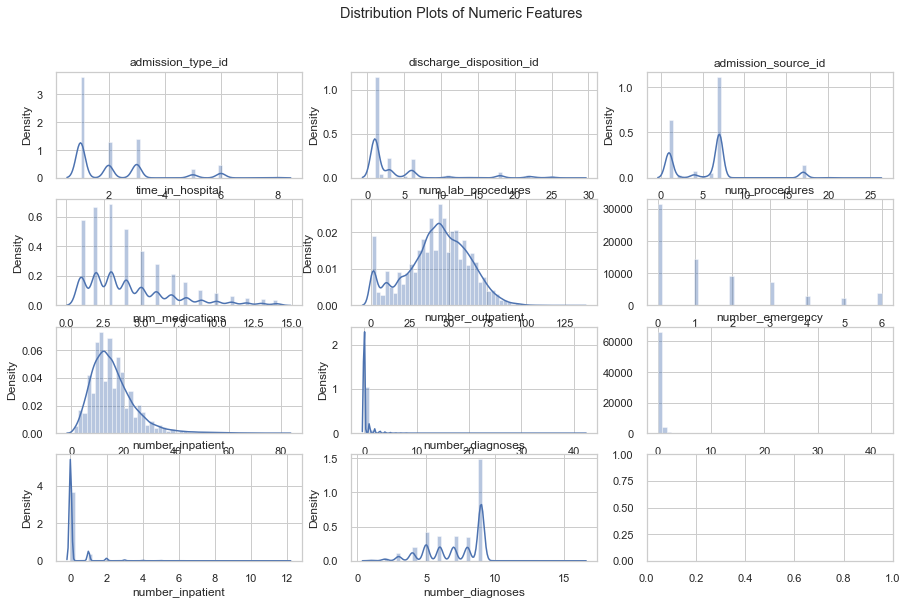

In [531]:
# Distribution Plots

fig, axes = plt.subplots(4,3, sharex=False, sharey=False, figsize=(15,9))
fig.suptitle('Distribution Plots of Numeric Features')

sns.distplot(numericFeatures['admission_type_id'], ax=axes[0,0], kde=True).set(title='admission_type_id')
sns.distplot(numericFeatures['discharge_disposition_id'], ax=axes[0,1], kde=True).set(title='discharge_disposition_id')
sns.distplot(numericFeatures['admission_source_id'], ax=axes[0,2], kde=True).set(title='admission_source_id')
sns.distplot(numericFeatures['time_in_hospital'], ax=axes[1,0], kde=True).set(title='time_in_hospital')
sns.distplot(numericFeatures['num_lab_procedures'], ax=axes[1,1], kde=True).set(title='num_lab_procedures')
sns.distplot(numericFeatures['num_procedures'], ax=axes[1,2], kde=False).set(title='num_procedures')
sns.distplot(numericFeatures['num_medications'], ax=axes[2,0], kde=True).set(title='num_medications')
sns.distplot(numericFeatures['number_outpatient'], ax=axes[2,1], kde=True).set(title='number_outpatient')
sns.distplot(numericFeatures['number_emergency'], ax=axes[2,2], kde=False).set(title='number_emergency')
sns.distplot(numericFeatures['number_inpatient'], ax=axes[3,0], kde=True).set(title='number_inpatient')
sns.distplot(numericFeatures['number_diagnoses'], ax=axes[3,1], kde=True).set(title='number_diagnoses')

plt.show()

In [532]:
# sns.pairplot(numericFeatures)

## General Data Clean-Up (Before Test/Train Split)

In [533]:
# Print Null Summary
nullSummary = nullAnalysis(mainData)
nullSummary

Count of Variables: 50
Count of Variables without nulls: 43
Count of Variables with null : 7


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
5,weight,71518,68665,96.011,9,object
11,medical_specialty,71518,34477,48.207,70,object
10,payer_code,71518,31043,43.406,17,object
2,race,71518,1948,2.724,5,object
20,diag_3,71518,1225,1.713,758,object
19,diag_2,71518,294,0.411,725,object
18,diag_1,71518,11,0.015,696,object


In [534]:
# Null Clean-Up1 -- Drop Columns with high % of nulls, that aren't worth filling
mainData = mainData.drop(columns=['weight','medical_specialty','payer_code'])

In [535]:
# Diag Clean-Up
## If diag_2 is null, then use diag_3.  If diag_1 is null, then use diag_2
## Solves all but 1 null Diag1, which is dropped
## TODO: Determine how to drop value from column that I pull from.
mainData['diag_2'] = mainData['diag_2'].fillna(mainData['diag_3'])
mainData['diag_1'] = mainData['diag_1'].fillna(mainData['diag_2'])
mainData = mainData.dropna(subset=['diag_1'])

In [536]:
# Remove Deceased Patients
## Note: The research question is about predicting what patients will be re-admitted.
## In order to not skew the resutls, patients who died while admitted should be removed from the prediction

# Create List of Deceased
## Note: I only removed cases that explicity said the patient expired.
## I did not remove patients who were transfered to hospice (13,14)

expCodes = ['11','19','20','21']
mainData = mainData[~mainData['discharge_disposition_id'].isin(expCodes)]

In [537]:
# Re-Run Null Summary
nullSummary = nullAnalysis(mainData)
nullSummary

Count of Variables: 47
Count of Variables without nulls: 44
Count of Variables with null : 3


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
2,race,70433,1921,2.727,5,object
17,diag_3,70433,1224,1.738,757,object
16,diag_2,70433,243,0.345,724,object


In [538]:
# Ordinal Encode Medication Variables

## Set List of Variabales
medCols = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
            'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
            'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
            'citoglipton','insulin','glyburide.metformin','glipizide.metformin','glimepiride.pioglitazone',
            'metformin.rosiglitazone','metformin.pioglitazone'] #Note: 'README' states 'sitagliptin' but not in data

## Define Func Params
df = mainData
listOfVars = medCols
order = ['No','Down','Steady','Up']

## Execute
mainData  = OrdinalEncoderFunc(df,listOfVars,order)

In [539]:
# Add Variable For Number of Medications

mainData.insert(47,"num_of_meds", 0)
mainData['num_of_meds'] = mainData[medCols].ne(0).sum(axis=1)

In [540]:
# Add Variable for Medication Level Up Or Down

## In the Medication columns 1 signifies that dosage decreased, 3 signifies that dosage increased
## This counts the number of 1 and coverts to a negative, then the adds the number of 3
## Result indicates the net level of medication change

mainData.insert(48,"med_level_direction", 0)
mainData['med_level_direction'] = ((mainData[medCols] == 1).sum(axis=1)*-1) + \
                                  (mainData[medCols] == 3).sum(axis=1)

### Replace Look-Up Values With Literal Values

In [541]:
# Add Admission Type Values (Note: Did not drop ID)

# Add Column
mainData.insert(7,"admission_type_value", 0)

# Left Join
mainData = pd.merge(mainData,admissionTypeLookUp,on='admission_type_id')

# Replace Values
mainData['admission_type_value'] = mainData['description']
mainData = mainData.drop(columns=['description'])
mainData.head(2)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_type_value,admission_source_id,time_in_hospital,...,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,num_of_meds,med_level_direction
0,24437208,135,Caucasian,Female,[50-60),2,1,Urgent,1,8,...,0.0,0.0,0.0,0.0,0.0,Ch,Yes,<30,3,-1
1,60254142,1314,Caucasian,Female,[40-50),2,1,Urgent,1,2,...,0.0,0.0,0.0,0.0,0.0,No,Yes,>30,1,0


## TODO: Test/Train Split
is implemented further down (temp) need to move up and change the following clean-up steps to the appropriate
test/train sets

## Additional Data Clean-Up (After Test/Train Split)

In [542]:
# Call Function w/ all custom clean-up steps
mainData = AdditionalClean(mainData) # Call Custom Clean-Up Function, Includes Encoding Response

# Run Models

## Prep -- Split Data
TODO: This is the wrong place - should be earlier in the code - adding here for now to just get the models working
and because I was confused by where to split based on needing to clean the response variable (ie should I split twice)

TODO: Don't yet know how to deal with multiple response variables.  First pass will keep it simple and only predict
if readmitted is yes/no.  Will need to add timeline response variables later

In [543]:
# TEMP: Create copy of mainData

tempModelingDF = mainData



In [544]:
# Drop columns that are not needed
# TODO: Needs to move up
varsToDrop = ['admission_type_id','admission_source_id','admission_type_value','discharge_disposition_id',
              'diag_1','diag_2','diag_3','number_diagnoses',
              'change','diabetesMed']

tempModelingDF = tempModelingDF.drop(columns=varsToDrop)

# TODO - Parking Lot
#'A1Cresult','max_glu_serum', 'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
              # number_outpatient','number_emergency','number_inpatient',

In [545]:
# TEMP
## Demographic Vars + Identifiers to Drop
tempModelingDF = tempModelingDF.drop(columns=['encounter_id','patient_nbr',])
## TODO - Parking Lot:
### 'gender', age_10yrStart

## Additional Response Vars to Drop
tempModelingDF = tempModelingDF.drop(columns=['readmitted__<30','readmitted__>30'])

In [546]:
# Set or Reset Test/Train Split
# Params
df=tempModelingDF #TODO - Change From temp DF
ResponseVar = 'readmitted' #TODO - Change from single response variable
PredictorVar = df.columns.values.tolist()
PredictorVar.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar, ResponseVar)

In [547]:
print("Complete List of Predicator Vars:")
PredictorVar

Complete List of Predicator Vars:


['gender',
 'age_10yrStart',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide.metformin',
 'glipizide.metformin',
 'glimepiride.pioglitazone',
 'metformin.rosiglitazone',
 'metformin.pioglitazone',
 'num_of_meds',
 'med_level_direction',
 'race__AfricanAmerican',
 'race__Asian',
 'race__Caucasian',
 'race__Hispanic',
 'race__Other',
 'race__Unknown']

## Random Forest

In [548]:
# Random Forest
## Set and Fit Model
rndClf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=32,n_jobs=-1)
rndClf.fit(x_train,y_train)

## Make Predictions
y_pred = rndClf.predict(x_test)

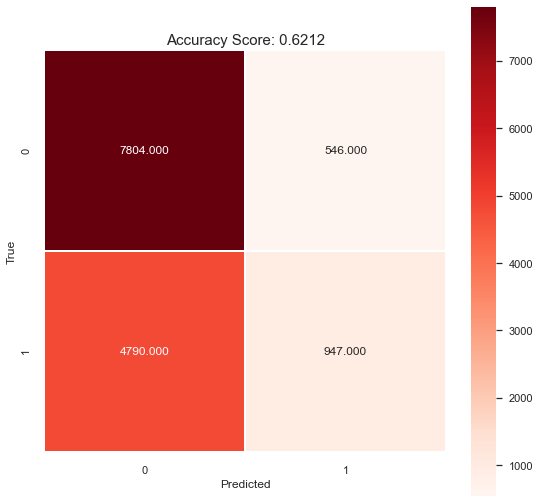

In [549]:
# Random Forest -- Plot CM
regObj = rndClf # update mode
cm_y_test = y_test
cm_y_pred = y_pred # Update yPred
cm_x_test = x_test

cm, score = createConfMatrix(regObj,cm_y_test, cm_y_pred, cm_x_test)

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);

In [550]:
# Random Forest -- Precision/Recall Scores

## Set Params
scores_y_test = y_test
scores_y_pred = y_pred # Update yPred

## Call Function
precision, recall, f1 = precisionRecall(scores_y_test, scores_y_pred)

## Print
print(f"Precision:",precision)
print(f"Recall:",recall)
print(f"F1:",f1)


Precision: 0.6343
Recall: 0.1651
F1: 0.262


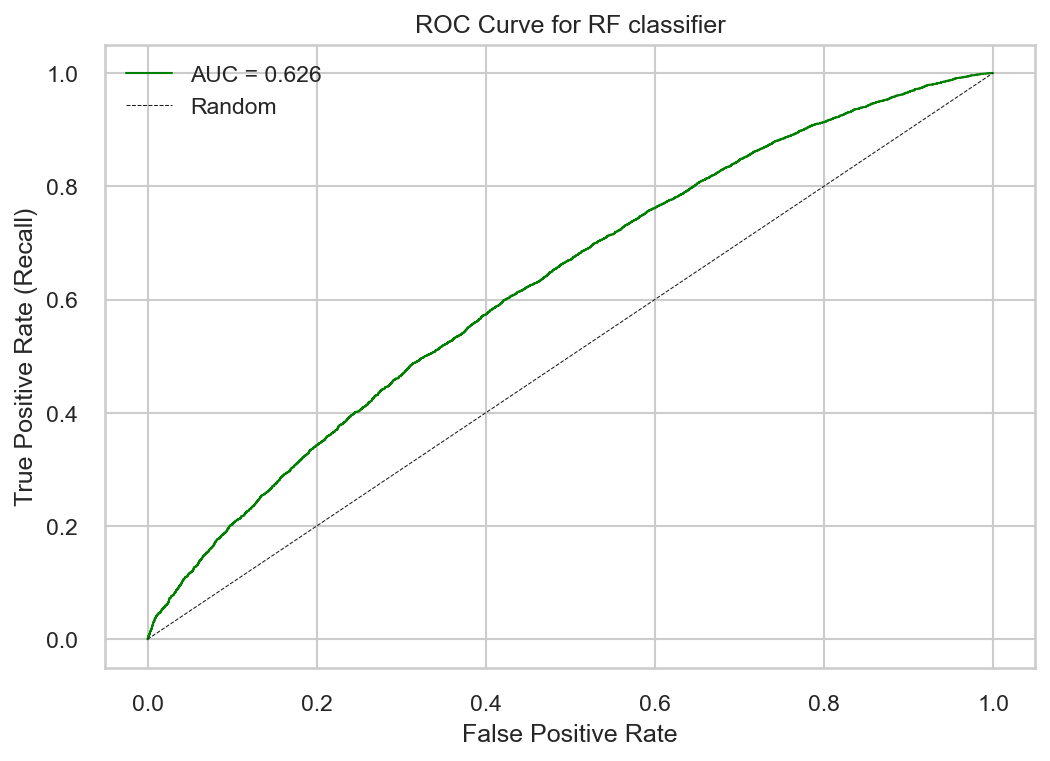

In [551]:
# ROC Curve/ AUC Score
## Set Params
model = rndClf
roc_x_test = x_test
roc_y_test = y_test # Update yPred

## Call Function
ROC_Curve_Plot(model,roc_x_test, roc_y_test)
plt.show()

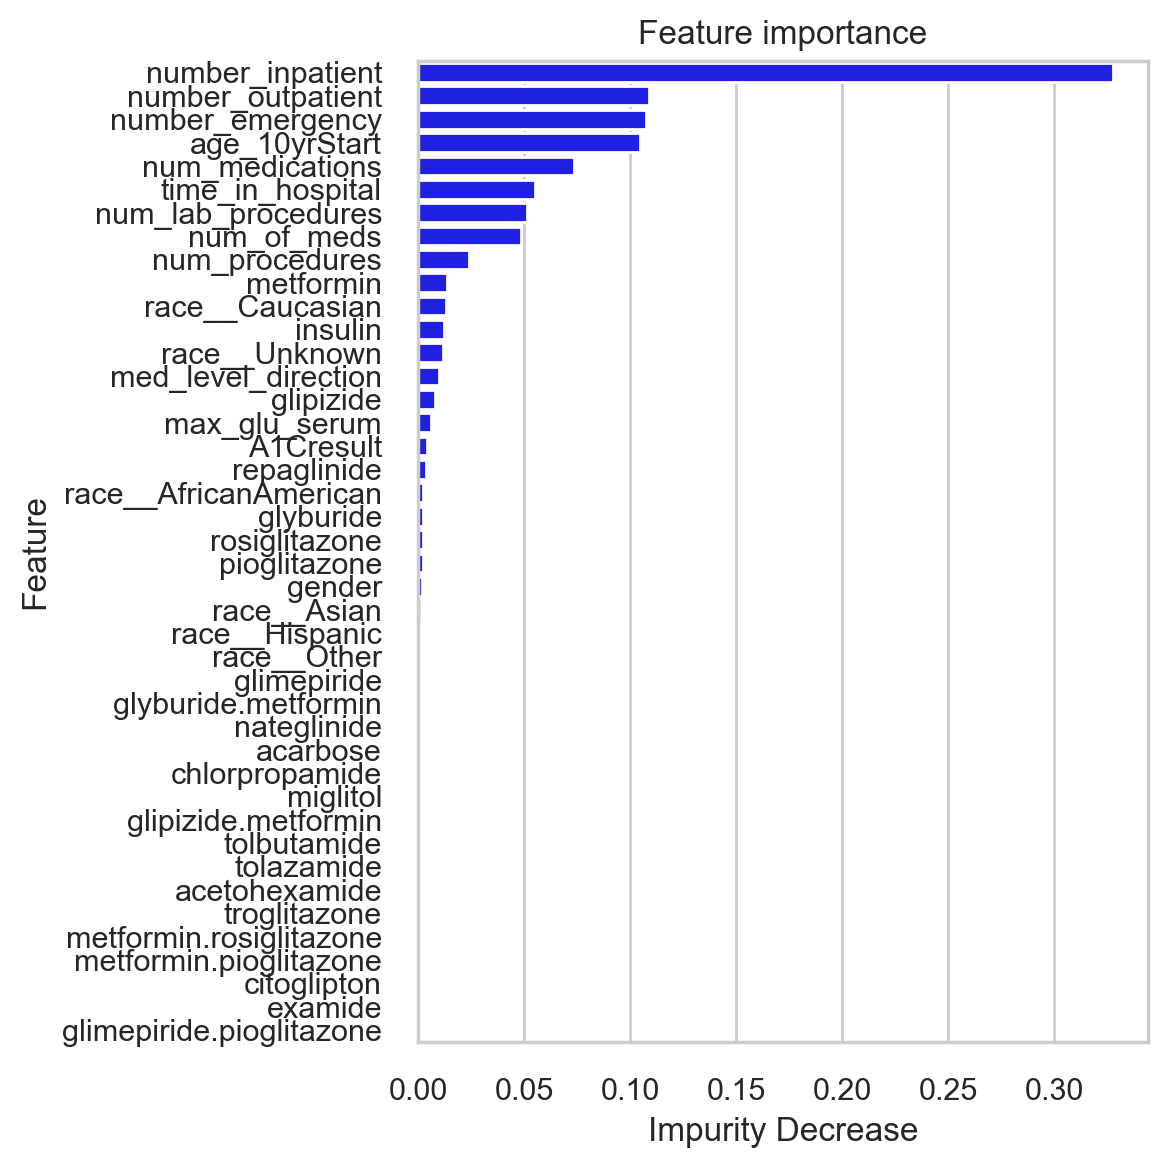

In [552]:
# Random Forest -- Feature Importance

# Best Tree-- Plot Most Important Features
feature_importances, fig = FeatureImportance(rndClf)
fig.show()

## Gradient Boosting

## Neural Network

## PCA

TODO - Basic Implementation using Previous example.  Need to do work to better interpret results.

In [553]:
predToRemove = {}

In [554]:
def testTrainSplit_PCA (df, PredictorVar,ResponseVar):
    df=df
    # Split into training/test
    x_all = df[PredictorVar]
    y = df[ResponseVar]
    pca = PCA()
    x = pca.fit_transform(scale(x_all))
    # Split Data Set Seed NP Random
    np.random.seed(1) # seed np random
    ## split data - use "random_state = any number (42) if you want reproducable splits.
    ### Remove random-state if you want random
    x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size = 0.2)
    return x_train, x_test, y_train, y_test, pca, x

In [555]:
cor = round(tempModelingDF.corr(),3)
responseVar = 'readmitted'
cor_target = abs(cor[responseVar])
#Selecting highly correlated features
PCA_relevant_features = cor_target[cor_target>=0.02] # Look for Features w/ greater 0.05 cor
PCA_relevant_features

age_10yrStart         0.072
time_in_hospital      0.062
num_lab_procedures    0.053
num_procedures        0.024
num_medications       0.039
number_outpatient     0.065
number_emergency      0.077
number_inpatient      0.145
max_glu_serum         0.022
metformin             0.023
repaglinide           0.020
glipizide             0.026
rosiglitazone         0.020
insulin               0.029
num_of_meds           0.036
race__Caucasian       0.039
race__Unknown         0.036
readmitted            1.000
Name: readmitted, dtype: float64

In [556]:
relFeatList = PCA_relevant_features.index.values.tolist()
PCA_df = tempModelingDF[relFeatList]
PCA_df

,age_10yrStart,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,max_glu_serum,metformin,repaglinide,glipizide,rosiglitazone,insulin,num_of_meds,race__Caucasian,race__Unknown,readmitted
0,50,8,77,6,33,0,0,0,0,2.0,0.0,0.0,0.0,2.0,3,1,0,1
1,40,2,50,5,13,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1,1,0,1
2,70,12,47,2,18,0,0,0,0,0.0,0.0,0.0,0.0,2.0,2,1,0,0
3,60,8,57,6,31,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1,1,0,0
4,80,2,38,0,8,0,0,0,0,0.0,2.0,0.0,0.0,0.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70428,50,6,61,1,14,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1,0,0,0
70429,80,4,66,0,16,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
70430,80,2,45,0,6,0,0,0,0,2.0,0.0,0.0,0.0,2.0,2,1,0,0
70431,10,9,45,6,23,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0


In [557]:
# Set or Reset Test/Train Split -- Do for Each Section
# Params
df=PCA_df
ResponseVar = 'readmitted'

PredictorVar = df.columns.values.tolist()
PredictorVar.remove(ResponseVar)
## Addition Predictor Vars to remove
PredictorVar = [ele for ele in PredictorVar if ele not in predToRemove]
PredictorVar

['age_10yrStart',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'max_glu_serum',
 'metformin',
 'repaglinide',
 'glipizide',
 'rosiglitazone',
 'insulin',
 'num_of_meds',
 'race__Caucasian',
 'race__Unknown']

In [558]:
# PCA -- CV
upper = len(PredictorVar)
row =[]
pca_Result = pd.DataFrame(columns = ["Number_Variables","MSE",'RMSE',"Variance_Explained"])
kf = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

# Function Call To prep train/test

for i in range(upper):
    x_train, x_test, y_train, y_test, pca, x  = testTrainSplit_PCA(df, PredictorVar[:i+1], ResponseVar)
    regr = LinearRegression()
    regr.fit(x_train, y_train)
    score = -1*model_selection.cross_val_score(regr, x_test, y_test, cv=kf,
                                               scoring='neg_mean_squared_error').mean()
    varExplained = 1-(pca.explained_variance_ratio_[i])
    RMSE = np.sqrt(score)
    row = [i,score,RMSE,varExplained]
    df_length = len(pca_Result)
    pca_Result.loc[df_length] = row
pca_Result

,Number_Variables,MSE,RMSE,Variance_Explained
0,0.0,0.240628,0.490539,0.000000
1,1.0,0.240071,0.489970,0.564339
2,2.0,0.239772,0.489665,0.782658
3,3.0,0.239606,0.489495,0.845824
4,4.0,0.239400,0.489286,0.906327
5,5.0,0.238634,0.488502,0.922355
6,6.0,0.238172,0.488029,0.933492
7,7.0,0.233832,0.483561,0.941809
8,8.0,0.233840,0.483570,0.948275
9,9.0,0.233860,0.483591,0.954585


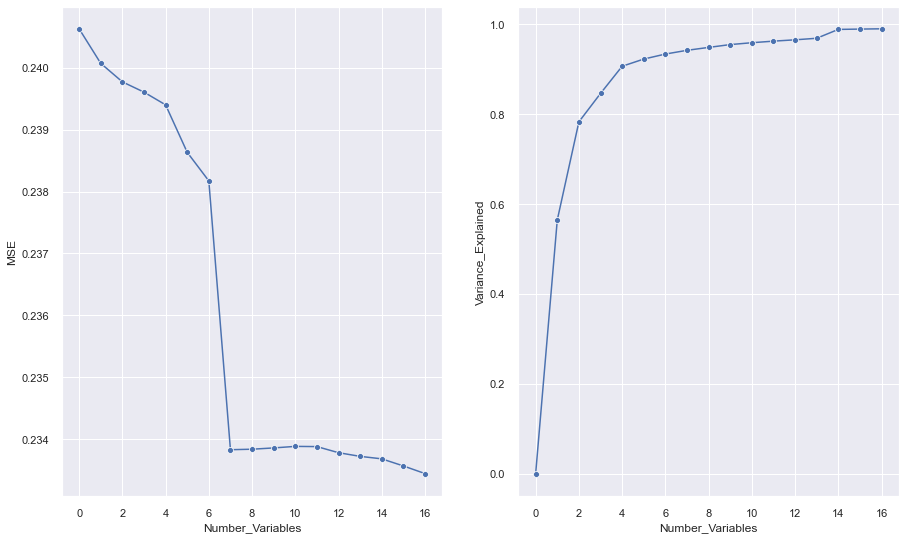

In [559]:
# PCA -- plot
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(5,5)})
fig, (ax1,ax2) = plt.subplots(ncols=2,sharex=True, sharey=False, figsize=(15,9))

sns.lineplot(
    data=pca_Result, ax=ax1,
    x="Number_Variables", y="MSE",
    marker="o", dashes=False)

sns.lineplot(
    data=pca_Result, ax=ax2,
    x="Number_Variables", y="Variance_Explained",
    marker="o", dashes=False)
#ax.set_ylabel("Error Rate")
#ax.set_xlabel("Depth")
plt.show()
#plt.savefig('Figures/PCA.png')

In [560]:
# PCA -- Interpret Results -- Transform Results
pca_BestM = PCA(n_components=0.8, random_state=1) #temp: replaced n_components=upper
X_scaled = scale(x_test)
pca_BestM.fit(X_scaled)
X_pca_bestM = pca_BestM.transform(X_scaled)
X_pca_bestM.shape

(14087, 14)

In [561]:
# PCA -- Interpret Results -- Transform Results into DF
PCA_ResultsDF = pd.DataFrame(X_pca_bestM, columns=['PC1','PC2','PC3','PC4',
                                                   'PC5','PC6','PC7','PC8',
                                                   'PC9','PC10','PC11','PC12',
                                                   'PC13','PC14',]) # Temp: 'PC15','PC16','PC17'

PCA_ResultsDF.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-0.764174,1.509540,-0.900270,0.013151,0.452765,0.843003,1.412601,-1.452524,0.530469,0.469827,-0.370099,-2.068877,0.815206,0.260998
1,-0.130230,-0.959520,0.604279,0.148951,0.073281,0.452862,4.565740,-0.276230,-0.099889,-3.355610,1.854333,0.843134,0.799519,-0.534138
2,-0.786837,0.256424,1.142520,0.128656,0.112030,-1.008825,-0.831599,0.071608,-0.574594,-1.104317,1.480620,-0.286915,-0.094369,-0.745024
3,0.919071,0.258798,-1.160559,-1.423232,0.398502,-0.949241,-1.207059,1.420299,-0.818013,0.402608,1.322339,0.786627,-0.721595,-0.973333
4,-0.808711,0.647387,-0.367325,0.086622,0.155162,1.736894,2.098385,0.868395,-0.056450,-1.799418,0.889219,1.511411,-0.707529,-0.428417


Text(0.5, 0, 'PC 3')

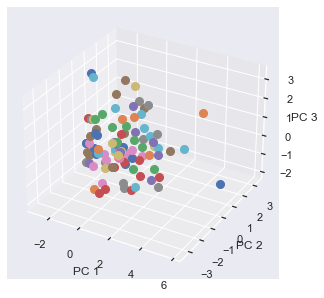

In [567]:
# TODO -- pg. 107 -- Don't understand this plot

# PCA -- Plot Results
from mpl_toolkits.mplot3d import Axes3D

#labels = PCA_df.target
#marker=r's{}s'.format(labels[i])
pca_forPlot_transformer = PCA(n_components=0.8)
pca_forPlot = pca_forPlot_transformer.fit_transform(x_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(100):
    ax.scatter(pca_forPlot[i,0], pca_forPlot[i,1],pca_forPlot[i,2],s=64)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# Experimentation/ Scratchpad

In [ ]:
expData.sample(10)

In [ ]:
#TODO - 1) Remove Response Vars from check 2) pull higher up probably in EDA

responseVar = 'readmitted'
corr = round(tempModelingDF.corr(),4)
corr = abs(corr[responseVar]).sort_values(ascending=False)

#Selecting highly correlated features
relevant_features = corr[corr>=0.04] # Look for Features w/ greater 0.05 cor
relevant_features

In [ ]:
#TEMP - Reduce to corrlated features.  If use this, then need to implement in a way that isn't manually keying in.
relevant_features_df = tempModelingDF[['readmitted','number_inpatient','number_emergency',
                                                      'age_10yrStart','number_outpatient','time_in_hospital',
                                                      'num_lab_procedures']]
relevant_features_df


In [ ]:
mainData['gender'].value_counts(dropna=False)

In [ ]:
expVars = ['num_of_meds','med_level_direction','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
            'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
            'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
            'citoglipton','insulin','glyburide.metformin','glipizide.metformin','glimepiride.pioglitazone',
            'metformin.rosiglitazone','metformin.pioglitazone','readmitted']

expSummaryVars = ['num_of_meds','med_level_direction','readmitted']

tempCor = mainData[expSummaryVars]
tempCor.sample(5)

In [ ]:
#Multiple Regression -- Check Correlations in HeatMap
plt.figure(figsize=(12,10))
cor = round(tempCor.corr(),3)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [ ]:
#Multiple Regressions -- Correlation with output variable
responseVar = 'readmitted'
cor_target = abs(cor[responseVar])
#Selecting highly correlated features
#relevant_features = cor_target[cor_target>=0.01] # Look for Features w/ greater 0.05 cor
#relevant_features
cor_target

In [ ]:
mainData.shape

In [ ]:
mainData['max_glu_serum'].value_counts(dropna=False)